In [1]:
import os
import numpy as np
from PIL import Image
import argparse
import cv2
import scipy.sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import imutils
import pandas as pd

import itertools
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import time
import random
import math

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

!conda info --env

%matplotlib inline



# conda environments:
#
base                     C:\Users\yongwook\anaconda3
outline               *  C:\Users\yongwook\anaconda3\envs\outline



In [2]:

import sys



def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

# ML Playground (CNN, mostly)

## Creating Dataset
Based on above information, we can create custom dataset. 사실 Dataset만 상속받고 나머지는 알아서 잘 해도 된다 하더라.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://blog.paperspace.com/dataloaders-abstractions-pytorch/
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



In [3]:
class PatchClassificationDataSet(Dataset):


    def __init__(self, data_dir: str, image_postfix:str, tsv_postfix:str,  landmark_regex:str, landmark_length:int):
        

        self.photo_img_string = image_postfix
        self.photo_tsv_string = tsv_postfix
        self.data_dir = data_dir
        self.landmark_regex = landmark_regex
        self.landmark_length = landmark_length

        files = os.listdir(self.data_dir)

        self.photo_images = [x for x in files if self.photo_img_string in x]
        self.photo_tsvs = [x for x in files if self.photo_tsv_string in x]
        assert(len(self.photo_images) == len(self.photo_tsvs))
        for i in range(len(self.photo_images)):
            x, y = self.photo_images[i], self.photo_tsvs[i]
            assert(os.path.splitext(x)[0] == os.path.splitext(y)[0])

    def __len__(self):
        return len(self.photo_tsvs * self.landmark_length)

    # load_tsv: load tsv --> return dataframe with name, x, y column.
    def load_tsv(self, name):
        # Loading dataframe
        df = pd.read_csv(os.path.join(self.data_dir, name),  sep='\t')
        df = df.iloc[:99, 0:3]
        
        df.columns = ['name', 'X', 'Y']

        return df


    # load_image: load image --> return plt.Image grayscale.
    def load_image(self, name):
        image = cv2.imread(os.path.join(self.data_dir, name), flags=cv2.IMREAD_GRAYSCALE)
        img = Image.fromarray(image)
        return img


    def extract_landmarks(self, df, landmark_regex, landmark_length):
        # (gathering only needed landmarks)
        df = df.loc[df['name'].str.contains(landmark_regex, regex=True), :]
        # there are **18** landmarks that is unique and valid among all files
        # should we sort df?
        df = df.sort_values(by=['name'])
        df = df.loc[:, ['X', 'Y']]
        df = df.reset_index(drop=True)

        # ... and landmark
        landmark = df.to_numpy(dtype=np.float32)
        return landmark

    # bounding_box: landmark --> return top, left, height, width
    def bounding_box(self, landmark):
        cx, cy = landmark
        width, height = random.randint(80, 160), random.randint(80, 160)
        
        top, left = cy - random.randint(0, height), cx - random.randint(0, width)

        return int(top), int(left), int(height), int(width)

    def check_within_bounding_box(self, landmark, top, left, height, width):
        onehot = [0] * self.landmark_length
        for i in range(len(landmark)):
            pos = landmark[i]
            x, y = pos[0], pos[1]
            #print(x, y)
            if left <= x and x <= left + width and top <= y and y <= top + height:
                onehot[i] = 1
        onehot = np.array(onehot, dtype=np.float32)
        onehot = torch.tensor(onehot)

        return onehot
    def rotate(self, img, landmark, angle):
        angle = random.uniform(-angle, +angle)

        
        transformation_matrix = torch.tensor([
            [+math.cos(math.radians(angle)), -math.sin(math.radians(angle))], 
            [+math.sin(math.radians(angle)), +math.cos(math.radians(angle))]
        ])

        image = imutils.rotate(np.array(img), angle)

        landmark = landmark - 0.5
        new_landmarks = np.matmul(landmark, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def crop(self, img, landmark, top, left, height, width):
        # Cropping image...
        img = TF.crop(img, top, left, height, width)
        #oh, ow = np.array(img).shape[0], np.array(img).shape[1]

        landmark = torch.tensor(landmark) - torch.tensor([[left, top]])
        landmark = landmark / torch.tensor([width, height])
        return img, landmark

    def normalize(self, img, landmark):
        # normalizing the pixel values
        img = TF.to_tensor(img)
        img = TF.normalize(img, [0.6945], [0.33497])


        landmark -= 0.5
        return img, landmark

    def __getitem__(self, index):

        divided = index // self.landmark_length
        remainder = index % self.landmark_length
        
        img_name = self.photo_images[divided]
        tsv_name = self.photo_tsvs[divided]

        img = self.load_image(img_name)
        df = self.load_tsv(tsv_name)

        
        landmark = self.extract_landmarks(df, self.landmark_regex, self.landmark_length)
     
        top, left, height, width = self.bounding_box(landmark[remainder])
        onehot = self.check_within_bounding_box(landmark, top, left, height, width)

        img, landmark = self.crop(img, landmark, top, left, height, width)

        # resizing image..
        img = TF.resize(img, (224, 224))
        # packing image
        # use dsplit when RGB to make 224x224x3 --> 3x224x224
        #img = np.dsplit(img, img.shape[-1])

        img, landmark = self.rotate(img, landmark, 10)

        img, landmark = self.normalize(img, landmark)
        
        #arr = arr.flatten('F')

        return img, onehot

In [4]:
data_dir = "./AutoAlign"
weights_path = 'face_classification_patch_'

landmark_regex_string = '29@[2479]|30@[34]' # for 18: '29@[1-9]\d?|30@[1-7]'
landmark_number = 6

photo_postfix = "lat_photo.jpg"
tsv_postfix = "lat_photo.txt"


dataset = PatchClassificationDataSet(data_dir, photo_postfix, tsv_postfix, landmark_regex = landmark_regex_string, landmark_length = landmark_number)

# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])


data_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(len(data_train_loader))

valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

The length of Train set is 2722
The length of Valid set is 302
43


Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 6])
Label: tensor([0., 0., 0., 0., 0., 1.])


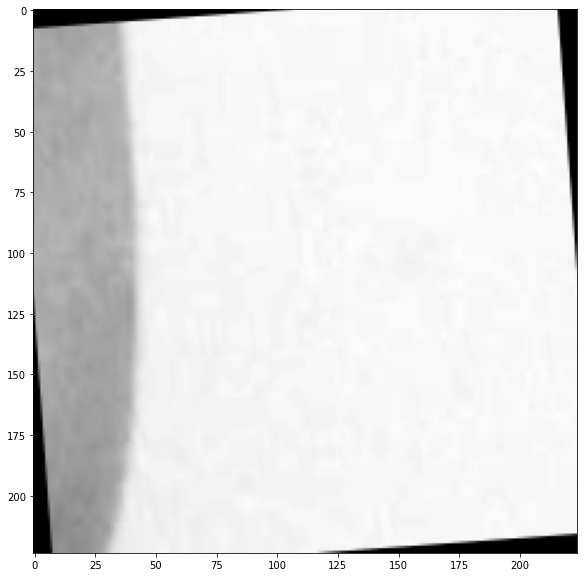

In [5]:
# Display image and label.
train_features, train_labels = next(iter(data_train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]

print(f"Label: {label}")
plt.figure(figsize=(10, 10))
plt.imshow(img.squeeze(), cmap='gray')


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Network
Based on https://colab.research.google.com/drive/1-28T5nIAevrDo6MwN0Qi_Cgdy9TEiSP_?usp=sharing#scrollTo=XH_bqPXo6YG8

Resnext50을 이용한다. 일단은 Greyscale(컬러로 확장도 가능하나 실익이 크지 않다.)

https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/



In [7]:
class Network(nn.Module):
    def __init__(self,num_classes=6):
        super().__init__()
        self.model_name='resnext50'
        #self.model=models.resnet18(pretrained=True)
        self.model=models.resnext50_32x4d(pretrained=True)


        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

        for param in self.parameters():
            param.requires_grad = False

        # RGB:        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc=nn.Sequential(nn.Dropout(p=0.2), nn.Linear(self.model.fc.in_features, num_classes))
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        x=self.sigm(self.model(x))
        return x

## Training
그림이 커서 그런지 초반에는 구데기로 나오고, 최소 100 epoch 이상은 해 줘야 할 것 같다.

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- http://incredible.ai/artificial-intelligence/2017/05/13/Transfer-Learning/#%EC%83%88%EB%A1%9C-%ED%9B%88%EB%A0%A8%ED%95%A0-%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B0%80-%EC%A0%81%EC%9C%BC%EB%A9%B0-original-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%99%80-%EB%8B%A4%EB%A5%B8-%EA%B2%BD%EC%9A%B0
- https://hanqingguo.github.io/Face_detection


In [8]:
# %%capture cap_out --no-stderr

torch.autograd.set_detect_anomaly(True)
network = Network(num_classes=6)
# use load_state_dict to load previously trained model.
# checkpoint = torch.load(f"model/0518_1226_6_100_face_landmarks_transfer_resnext50.tar"))
# use pth only
# network.load_state_dict(torch.load(f"model/0525_1926_6_100_face_landmarks_transfer__resnext50.pth"))
# use checkpoint
# network.load_state_dict(checkpoint['network_state_dict'])

network.to(device)
print(network)

criterion = nn.BCELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=0.001)
# Load optimizer too
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

loss_min = np.inf
num_epochs = 50

logger = pd.DataFrame(columns=['train loss', 'valid loss'])

start_time = time.time()
time_str = time.strftime(f"%m%d_%H%M")
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(data_train_loader)+1):
    
        images, landmarks = next(iter(data_train_loader))
        
        images = images.to(device)
        landmarks = landmarks.to(device)
        # landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        
        predictions = network(images)
        
        optimizer.zero_grad()
        
        loss_train_step = criterion(predictions, landmarks)

        loss_train_step.backward()
        
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(data_train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.to(device)
            landmarks = landmarks.to(device)
            
            # landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(data_train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    logger.loc[epoch - 1] = [loss_train, loss_valid]

    if loss_valid < loss_min:
        loss_min = loss_valid
        # torch.save(network.state_dict(), f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.pth") 
        torch.save({
            'network_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.tar")
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
    # cap_out.show()
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
logger.to_csv(f'csv/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_train_data.csv')
# cap_out.show()
# with open(f'csv/{time_str}_{landmark_number}_{num_epochs}_train_log.txt') as capture_file:
#     capture_file.write(cap_out)



lse)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): Bottleneck(
        (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (layer2): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


tensor([0.0402, 0.3767, 0.0742, 0.1716, 0.1375, 0.1085])
tensor([0.1269, 0.0726, 0.7142, 0.1556, 0.0824, 0.1031])
tensor([0.8988, 0.0249, 0.1819, 0.0468, 0.1888, 0.0392])
tensor([0.0231, 0.4248, 0.1099, 0.2887, 0.2366, 0.0635])
tensor([0.0070, 0.1226, 0.3555, 0.1388, 0.5087, 0.6860])
tensor([0.1828, 0.0480, 0.5730, 0.2770, 0.1236, 0.0717])
tensor([0.0019, 0.2618, 0.5818, 0.3154, 0.3556, 0.1574])
tensor([0.0167, 0.1734, 0.5111, 0.8278, 0.5377, 0.0172])
Total number of test images: 302
Elapsed Time : 1.1559524536132812


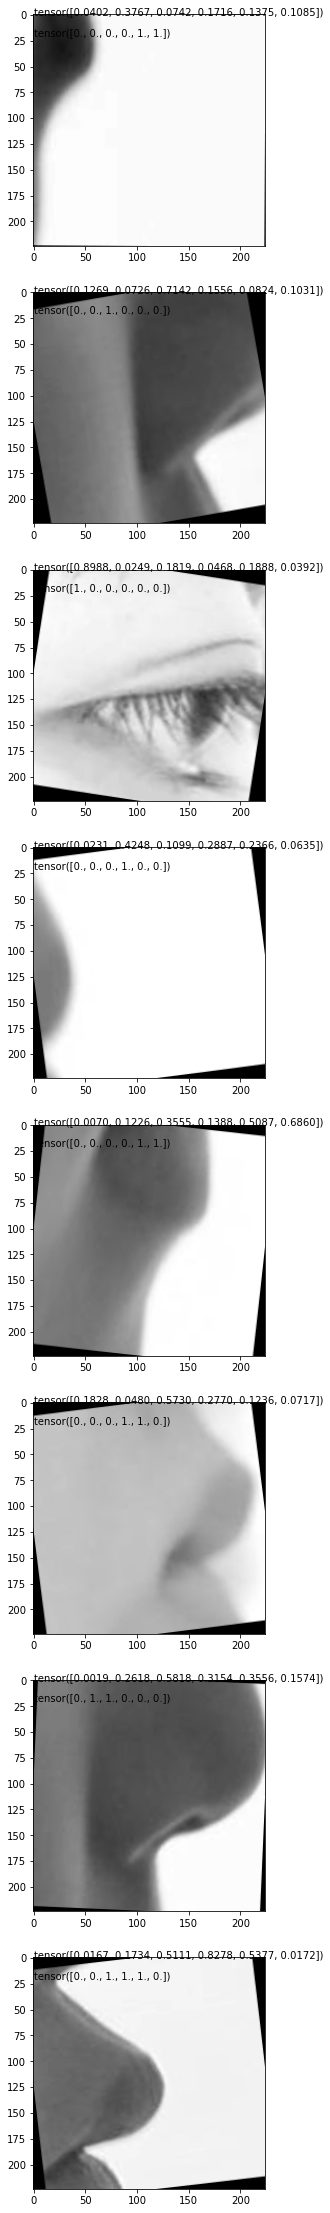

In [14]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load(f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.tar")['network_state_dict'])
    best_network.eval()
    
    images, classification = next(iter(valid_loader))
    images = images.cuda()

    predictions = best_network(images).cpu()

    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        print(predictions[img_num])
        plt.text(0, 0, predictions[img_num, :])
        plt.text(0, 20, classification[img_num, :])
        
print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

## From Face detection to landmark detection, IRL

https://github.com/timesler/facenet-pytorch

- With pip:
pip install facenet-pytorch

- or clone this repo, removing the '-' to allow python imports:
git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

- or use a docker container (see https://github.com/timesler/docker-jupyter-dl-gpu):
docker run -it --rm timesler/jupyter-dl-gpu pip install facenet-pytorch && ipython

In [16]:
def crop_image(image, size):
    images = []
    p0s = []
    width, height = image.size
    for i in range(0, height, size):
        for j in range(0, width, size):
            box = (j, i, j+size, i+size)
            a = image.crop(box)
            images.append(a)
            p0s.append((j, i))

    return images, p0s

In [20]:
class PatchNetwork(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.model_name='resnext50'
        #self.model=models.resnet18(pretrained=True)
        self.model=models.resnext50_32x4d(pretrained=True)


        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

        for param in self.parameters():
            param.requires_grad = False

        # RGB:        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

        
    def forward(self, x):
        x=self.model(x)
        return x

773 1142
tensor([[0.1925, 0.0799]])
[[498.39637089 399.39078617]]
tensor([[0.1799, 0.0844]])
[[577.3884325  399.75388813]]
tensor([[0.3131, 0.3597]])
[[428.05167961 501.77879143]]
tensor([[0.3348, 0.0896]])
[[509.78758144 480.16418743]]
tensor([[ 0.1682, -0.1127]])
[[576.45604897 463.9819603 ]]
tensor([[0.0869, 0.1442]])
[[409.94868088 564.53974533]]


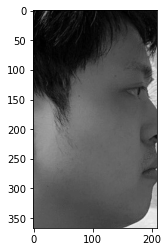

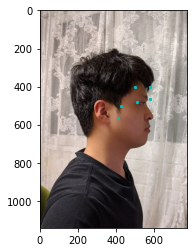

took about 11.209654331207275s
from image open, took 11.082658529281616s
from inference, took 10.930662393569946s


In [32]:
from facenet_pytorch import MTCNN, InceptionResnetV1

start = time.time()

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=224, device=device)

#######################################################################
image_path = 'prop.jpg'

patch_size = 80


#######################################################################



image_open = time.time()
input_image = Image.open(image_path)
grayscale_image = input_image.convert('L')
height, width = input_image.size[0], input_image.size[1]
print(height, width)
# Get cropped and prewhitened image tensor
boxes, probs = mtcnn.detect(input_image)
face = boxes[0]
x0, y0, x1, y1 = face
x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1) 

#face = (faces + 1) * 255

# image = np.array(grayscale_image)
# image = image[y0:y1, x0:x1]
# image = TF.crop(grayscale_image, y0, x0, y1-y0, x1-x0)
image = TF.crop(grayscale_image, y0, x0, y1-y0, x1-x0)
plt.imshow(image, cmap='gray')
patches, p0s = crop_image(image, patch_size)

slot = [[], [], [], [], [], []]

from_image_inference = time.time()

base_network = Network(num_classes=6)
base_network.load_state_dict(torch.load(f"model/0526_1827_6_50_face_classification_patch__resnext50.tar")['network_state_dict'])
base_network.eval()


for i in range(len(patches)):
   patch, p0 = patches[i], p0s[i]
   # image = TF.resize(Image.fromarray(image), size=(224, 224))
   patch = TF.to_tensor(patch)
   patch = TF.normalize(patch, [0.6945], [0.33497])

   with torch.no_grad():
      possiblity = base_network(patch.unsqueeze(0))

   for i in range(6):
      prob = possiblity[0][i]
      #print(p0, i, prob)
      if prob > 0.95:
         slot[i].append((patch, p0))
   
patch_net = PatchNetwork(num_classes=2)
patch_net.load_state_dict(torch.load(f"model/0526_1005_29@2_100_face_landmarks_patch__resnext50.tar")['network_state_dict'])
patch_net.eval()


all_landmarks = []
#for each_patches in slot:
each_patches = slot[0]
for (patch, p0) in each_patches:
   # second inference using landmark and bounding box
   # use for i in range(6) for real case.
   # for testing, testing using landmarks[0,0:2]
   patch = TF.resize(patch, (224, 224))


   with torch.no_grad():
         single_landmark = patch_net(patch.unsqueeze(0))

   print(single_landmark)

   single_landmark = (single_landmark.view(1,2).detach().numpy() + 0.5) * np.array([[patch_size,patch_size]]) + np.array([p0]) + np.array([[x0, y0]])
   print(single_landmark)
   all_landmarks.append((0, single_landmark)) # 0 here is landmark 0(29@2)

plt.figure()
plt.imshow(input_image)
for (number, ld) in all_landmarks:
   plt.scatter(ld[:,0], ld[:,1], c = 'c', s = 5)
plt.savefig('result.png', dpi=300)
plt.show()

end = time.time()
print(f"took about {end - start}s")
print(f"from image open, took {end - image_open}s")
print(f"from inference, took {end - from_image_inference}s")